# Multiclass Text Classification with 
# Logistic Regression Implemented with PyTorch and CE Loss

First, we will do some initialization.

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [2]:
train_df = pd.read_csv('data/ag_news_csv/train.csv', header=None)
train_df.columns = ['class index', 'title', 'description']
train_df

,class index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [3]:
labels = open('data/ag_news_csv/classes.txt').read().splitlines()
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)
train_df

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Let's inspect how balanced our examples are by using a bar plot.

<AxesSubplot:>

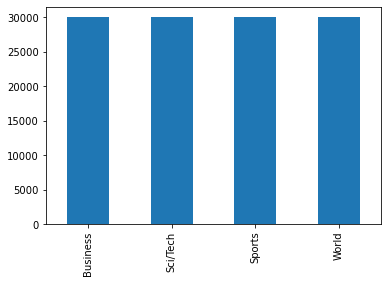

In [4]:
pd.value_counts(train_df['class']).plot.bar()

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [5]:
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [6]:
title = train_df['title'].str.lower()
descr = train_df['description'].str.lower()
text = title + " " + descr
train_df['text'] = text.str.replace('\\', ' ', regex=False)
train_df

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [7]:
from nltk.tokenize import word_tokenize

train_df['tokens'] = train_df['text'].progress_map(word_tokenize)
train_df

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi..."


Now we will create a vocabulary from the training data. We will only keep the terms that repeat beyond some threshold established below.

In [8]:
threshold = 10
tokens = train_df['tokens'].explode().value_counts()
tokens = tokens[tokens > threshold]
id_to_token = ['[UNK]'] + tokens.index.tolist()
token_to_id = {w:i for i,w in enumerate(id_to_token)}
vocabulary_size = len(id_to_token)
print(f'vocabulary size: {vocabulary_size:,}')

vocabulary size: 19,671


In [9]:
from collections import defaultdict

def make_feature_vector(tokens, unk_id=0):
    vector = defaultdict(int)
    for t in tokens:
        i = token_to_id.get(t, unk_id)
        vector[i] += 1
    return vector

train_df['features'] = train_df['tokens'].progress_map(make_feature_vector)
train_df

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens,features
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac...","{427: 2, 563: 1, 1607: 1, 15062: 1, 120: 1, 73..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace...","{15999: 2, 1076: 1, 855: 1, 1286: 1, 4251: 1, ..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,...","{66: 1, 9: 2, 351: 2, 4565: 1, 158: 1, 116: 1,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe...","{77: 2, 7380: 1, 66: 3, 1787: 1, 32: 2, 900: 2..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p...","{66: 2, 99: 2, 4390: 1, 4: 2, 3595: 1, 149: 1,..."
...,...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,...","{383: 1, 23: 1, 1626: 2, 91: 1, 1809: 1, 285: ..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s...","{8428: 2, 2638: 1, 5: 4, 0: 3, 127: 1, 202: 3,..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi...","{7762: 2, 68: 1, 661: 1, 4: 2, 1439: 2, 703: 1..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi...","{106: 1, 23: 1, 729: 1, 225: 1, 1586: 1, 22: 1..."


In [10]:
def make_dense(feats):
    x = np.zeros(vocabulary_size)
    for k,v in feats.items():
        x[k] = v
    return x

X_train = np.stack(train_df['features'].progress_map(make_dense))
y_train = train_df['class index'].to_numpy() - 1

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train)

  0%|          | 0/120000 [00:00<?, ?it/s]

In [11]:
from torch import nn
from torch import optim

# hyperparameters
lr = 1.0
n_epochs = 5
n_examples = X_train.shape[0]
n_feats = X_train.shape[1]
n_classes = len(labels)

# initialize the model, loss function, optimizer, and data-loader
model = nn.Linear(n_feats, n_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# train the model
indices = np.arange(n_examples)
for epoch in range(n_epochs):
    np.random.shuffle(indices)
    for i in tqdm(indices, desc=f'epoch {epoch+1}'):
        # clear gradients
        model.zero_grad()
        # send datum to right device
        x = X_train[i].unsqueeze(0).to(device)
        y_true = y_train[i].unsqueeze(0).to(device)
        # predict label scores
        y_pred = model(x)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()

epoch 1:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/120000 [00:00<?, ?it/s]

Next, we evaluate on the test dataset

In [12]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('data/ag_news_csv/test.csv', header=None)
test_df.columns = ['class index', 'title', 'description']
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)
test_df['features'] = test_df['tokens'].progress_map(make_feature_vector)

X_test = np.stack(test_df['features'].progress_map(make_dense))
y_test = test_df['class index'].to_numpy() - 1
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [13]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

# don't store gradients
with torch.no_grad():
    X_test = X_test.to(device)
    y_pred = torch.argmax(model(X_test), dim=1)
    y_pred = y_pred.cpu().numpy()
    print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       World       0.94      0.82      0.88      1900
      Sports       0.89      0.99      0.94      1900
    Business       0.81      0.88      0.85      1900
    Sci/Tech       0.89      0.83      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

